<a href="https://colab.research.google.com/github/jonisabdulkarim/CE888/blob/main/Lab4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url = "https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv"
df = pd.read_csv(url, header=None)

In [3]:
df # check no. of rows and columns matches 24983 X 101

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.00,99.00,99.00,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.00,99.00,99.00,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.00,99.00,99.00,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,100,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,-0.53,5.63,-7.14,-4.08,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46,5.63,-0.92,-2.91,-4.17,2.82,3.40,8.64,6.84,6.80,-0.87,7.38,-3.50,8.88,7.43,5.39,2.23,-0.68,3.40,-0.58,...,8.59,3.45,0.87,9.27,-4.66,5.73,-0.49,8.35,1.94,5.00,-9.66,8.98,8.98,-9.81,9.13,9.08,9.08,3.98,0.73,9.03,8.98,9.22,8.93,9.13,9.27,-1.99,-9.95,-9.90,9.13,8.83,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,91,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,8.88,-8.69,-7.48,-8.83,-1.75,6.60,3.54,1.50,7.67,-0.44,9.22,8.74,9.03,9.08,8.93,3.74,3.20,-9.17,-8.98,8.79,-7.67,-3.06,9.13,8.40,-0.63,-7.18,0.58,8.88,9.27,...,2.77,8.11,-7.96,8.93,-0.87,-5.87,8.88,-1.12,-8.74,8.74,99.00,99.00,99.00,99.00,99.00,4.90,99.00,99.00,99.00,99.00,-0.29,0.92,-0.78,0.15,-0.10,0.00,-0.19,-0.87,-1.36,-0.58,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,39,99.00,99.00,99.00,99.00,-7.77,99.00,6.70,-6.75,99.00,99.00,99.00,99.00,-6.46,-1.65,-6.80,-6.41,-6.99,7.23,6.75,-6.99,6.55,99.00,99.00,99.00,99.00,0.49,-0.53,-6.94,-0.49,99.00,6.46,-0.53,99.00,99.00,-7.86,-0.34,99.00,-6.94,99.00,...,0.49,-0.24,99.00,99.00,-3.11,-6.65,99.00,-0.58,6.31,99.00,99.00,-7.86,99.00,99.00,

In [4]:
df_2 = df.replace(99, np.nan)

In [5]:
df_2 = df_2.drop(0, axis=1)

In [6]:
df_2.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [7]:
df_2.max()

1      9.37
2      9.37
3      9.37
4      9.37
5      9.37
       ... 
96     9.37
97     9.37
98     9.37
99     9.37
100    9.37
Length: 100, dtype: float64

In [8]:
df_2.min()

1     -9.95
2     -9.95
3     -9.95
4     -9.95
5     -9.95
       ... 
96    -9.95
97    -9.95
98    -9.95
99    -9.95
100   -9.95
Length: 100, dtype: float64

In [9]:
arr = df_2.values # this is the training set
print(arr.shape)

(24983, 100)


In [10]:
rated = np.where(arr!=99)
print(len(rated[0]), rated[1].shape) # n_rated

2498300 (2498300,)


In [11]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [12]:
new_arr, idx = replace(arr) # this is the validation set

In [13]:
print(new_arr)

[[-7.82  8.79 -9.66 ...   nan   nan   nan]
 [ 4.08 -0.29  6.36 ...  0.34 -4.32  1.07]
 [  nan   nan   nan ...   nan   nan   nan]
 ...
 [  nan   nan   nan ... 99.     nan   nan]
 [99.     nan   nan ...   nan   nan   nan]
 [ 2.43  2.67 -3.98 ...   nan   nan   nan]]


In [14]:
new_rated = np.where(new_arr!=99)
print(len(new_rated[0]), new_rated[1].shape) # n_rated

2248470 (2248470,)


In [18]:
n_latent_factors = 2

user_ratings = new_arr
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [19]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)

In [20]:
def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err

In [21]:
def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 1) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [22]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations

Iteration 0/10:	MSE=1180.752381
Iteration 1/10:	MSE=1079.624234
Iteration 2/10:	MSE=1057.311949
Iteration 3/10:	MSE=1056.558788
Iteration 4/10:	MSE=1059.138024
Iteration 5/10:	MSE=1061.573327
Iteration 6/10:	MSE=1063.417884
Iteration 7/10:	MSE=1064.604699
Iteration 8/10:	MSE=1065.886713
Iteration 9/10:	MSE=1068.692391


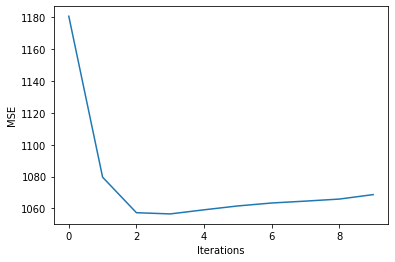

In [23]:
plt.figure()
plt.plot(np.arange(0, num_iter, 1), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [25]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[  9.54674722,   7.80770779,   9.55810894, ...,  16.45991296,
         16.70949133,  24.39375575],
       [ -0.71499971,  -0.71787583,  -0.72989338, ...,   1.51540526,
          1.20780015,   0.91960034],
       [ 34.2213808 ,  26.81062404,  34.13795051, ...,  83.30004944,
         81.640291  , 111.72562129],
       ...,
       [ 58.07490951,  47.98630051,  58.19575069, ...,  90.00651865,
         92.58894743, 138.27568948],
       [ 33.20822135,  27.11304395,  33.2428953 , ...,  58.20424946,
         58.97266979,  85.80145285],
       [ 13.19666265,   9.80111269,  13.10776133, ...,  43.22443626,
         41.41726847,  54.1796071 ]])

In [27]:
values = [zip(user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = df_2.columns

In [28]:
comparison_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, 9.546747222109863)","(8.79, 7.807707792561736)","(-9.66, 9.55810894405214)","(-8.16, 9.169037725499082)","(-7.52, 1.275710758950502)","(-8.5, 5.273007356887526)","(-9.85, 1.1246927264897217)","(4.17, 2.471310453568734)","(-8.98, 8.198329687815257)","(99.0, 5.180082773018081)","(-8.5, 2.179982605630198)","(-6.75, 4.88151124321674)","(-7.18, 1.2214239959311086)","(8.45, 4.901788505315108)","(-7.18, 1.7610513148866802)","(-7.52, 1.7474833752864003)","(-7.43, 1.8447058206441167)","(-9.81, 1.5879372036192592)","(-9.85, 2.1798932378454556)","(-9.85, 1.6379436930482087)","(-9.37, 4.164055780011504)","(1.5, 6.177310210468465)","(-4.37, 4.8819816907253655)","(-9.81, 9.286022467329044)","(-8.5, 3.85174594720112)","(1.12, 3.710849221369922)","(7.82, 3.243316081660729)","(2.86, 3.601640172668928)","(9.13, 3.273387862863777)","(99.0, 8.618015597084774)","(2.14, 2.5596603765243575)","(-4.08, 3.3402807593882278)","(-9.08, 10.318717852336224)","(7.82, 4.3724775130536955)","(5.05, 2.9821389959269253)","(4.95, 3.870863645137614)","(-9.17, 8.050665439737042)","(-8.4, 3.7261648221286428)","(-8.4, 3.6630219293102986)","(99.0, 4.577597303941356)",...,"(99.0, 2.9473696099912168)","(3.59, 3.863400547019227)","(-6.84, 6.778892958661469)","(-9.03, 10.244339258509122)","(2.82, 3.803633463322449)","(-1.36, 3.550817300348458)","(-9.08, 9.173521719939764)","(8.3, 2.9712107013021534)","(5.68, 3.856379892832911)","(-4.81, 7.1066168332001345)","(nan, 14.30644074362167)","(nan, 15.448855837107166)","(nan, 16.873034056863943)","(nan, 14.707322755494248)","(nan, 15.936132592540998)","(nan, 17.918289090153003)","(nan, 17.41645146724491)","(-9.42, 16.942485070935508)","(nan, 16.953280390460012)","(nan, 18.429032243549013)","(nan, 16.83114553901317)","(-7.72, 17.611505012842628)","(nan, 18.39037106056456)","(nan, 17.987619083563292)","(nan, 18.182837968537754)","(nan, 17.801517317457556)","(99.0, 17.63394670146526)","(nan, 17.82774416325667)","(nan, 18.496132417911134)","(nan, 17.663485574668865)","(2.82, 18.24759813859848)","(nan, 15.593005855905407)","(nan, 18.30252059023709)","(nan, 16.744169504644567)","(nan, 16.679552366581515)","(nan, 17.24845911616585)","(-5.63, 17.424035377148705)","(nan, 16.45991295633685)","(nan, 16.709491332754418)","(nan, 24.393755753287447)"
1,"(4.08, -0.7149997083581953)","(-0.29, -0.7178758263442273)","(6.36, -0.7298933755686859)","(4.37, -0.13739362142768832)","(-2.38, 1.7359647942745695)","(-9.66, 0.26273227888416345)","(-0.73, 1.6972827464141176)","(-5.34, 0.4016236759359682)","(8.88, 0.5851497049596573)","(99.0, 0.3190510260336141)","(6.75, 1.965101037731903)","(8.64, -0.09066824680166415)","(99.0, 1.2874219318394136)","(7.43, -0.10224997583679374)","(4.56, 0.7293499238555851)","(-0.97, 0.5219857205612287)","(4.66, 1.040504098089775)","(-0.68, 1.2281080813209102)","(3.3, 0.9291951561123698)","(-1.21, 1.1946136070150324)","(0.87, 0.03600682846792382)","(8.64, -0.6217640180252703)","(8.35, 0.3734995918540497)","(9.17, -0.04480363903603941)","(0.05, 0.9431283254794074)","(7.57, 0.4974311773973329)","(4.71, 1.0942188831287054)","(0.87, 0.5072496320304164)","(-0.39, 0.9527878897903476)","(6.99, -0.5332664887984105)","(6.5, 1.435651351665597)","(-0.92, 0.9342587309800983)","(7.14, -0.8243977993286983)","(9.03, 0.6060538110919161)","(-1.8, 1.2116929659867406)","(0.73, 0.5764543933162837)","(7.09, -0.023758955726570503)","(3.4, 0.8223344660215102)","(-0.87, 0.6651800072290045)","(7.91, 0.3635030000137859)",...,"(-6.7, 0.9194207253257679)","(-3.35, 0.5368445561034835)","(-9.03, -0.3209897042212474)","(4.47, -0.7683984030100351)","(4.08, 0.602739625207788)","(-3.83, 0.8677553985213673)","(99.0, -0.37055078342729864)","(1.12, 1.2936906981362644)","(0.78, 0.4028539404447786)","(7.52, -0.41688275375